Write a function that can shift an MNIST image in any direction (left, right, up or down) by one pixel. Then, for each image in the training set, create four shifted copies(one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuarcy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data argumentation or training set expansion.

In [1]:
from sklearn.datasets import fetch_openml
# La descarga de el dataset de sklearn se guarda por default en el directorio de usuario como 'scikit_learn_data'

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

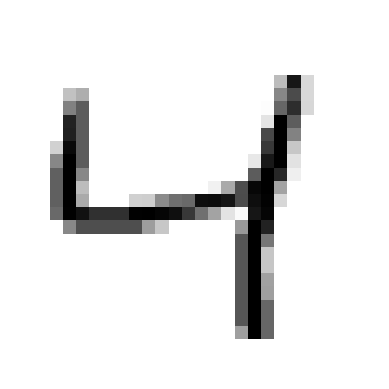

In [3]:
import matplotlib.pyplot as plt

#The images are 28x28 pixels
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[2]
plot_digit(some_digit)
plt.show()

In [4]:
# For convenience, split the data into a training set and a test set
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
from scipy.ndimage import shift
import numpy as np

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

# Example of shifting an image
shifted_image = shift_image(some_digit, 5, -10)

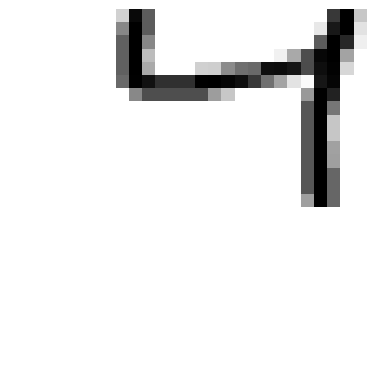

In [6]:
plot_digit(shifted_image)
plt.show()

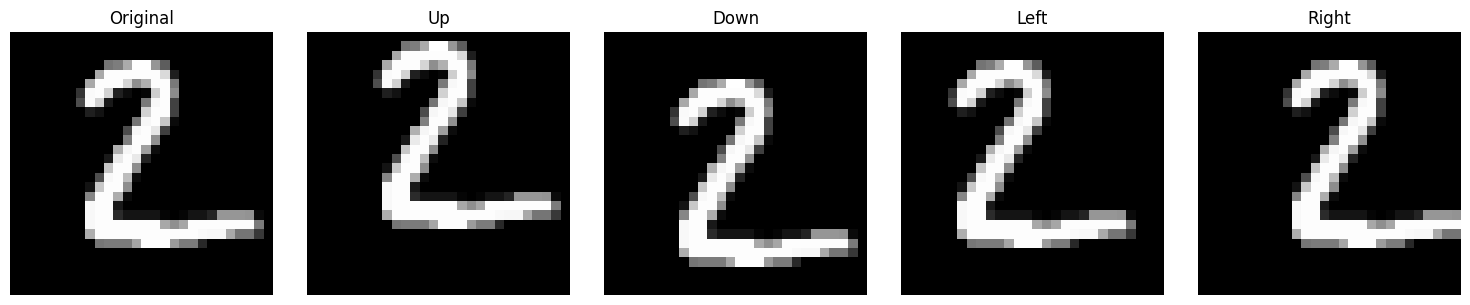

In [7]:
def interpolate_image(image, pixels=2):
    """
    Interpolate an image by generating shifted versions in 4 directions.
    
    Parameters:
    - image: element from x_test (array of 784 elements for MNIST)
    - pixels: number of pixels to shift (default 2)
    
    Returns:
    - dict with keys: 'original', 'up', 'down', 'left', 'right'
      Each value is the flattened image (784 elements)
    """
    interpolated = {
        'original': image.copy(),
        'up': shift_image(image, dx=0, dy=-pixels),      # up: negative dy
        'down': shift_image(image, dx=0, dy=pixels),     # down: positive dy
        'left': shift_image(image, dx=-pixels, dy=0),    # left: negative dx
        'right': shift_image(image, dx=pixels, dy=0)     # right: positive dx
    }
    return interpolated

# Example usage:
test_element = x_test[1]  # Choose one element from x_test
interpolated_versions = interpolate_image(test_element, pixels=2)

# Visualize the 5 versions
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
directions = ['original', 'up', 'down', 'left', 'right']

for idx, direction in enumerate(directions):
    axes[idx].imshow(interpolated_versions[direction].reshape(28, 28), cmap='gray')
    axes[idx].set_title(direction.capitalize())
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [8]:
def augment_dataset(X, y, pixels=2):
    """
    Amplifies the dataset using image interpolation.
    For each image, creates 4 shifted versions (up, down, left, right).
    
    Parameters:
    - X: set of images (n_samples, 784)
    - y: corresponding labels (n_samples,)
    - pixels: pixels to shift in each direction
    
    Returns:
    - X_augmented: new set with original + interpolated images
    - y_augmented: duplicated labels to maintain correspondence
    
    Example: 10,000 images → 50,000 images (5x more)
    """
    X_augmented = []
    y_augmented = []
    
    print(f"Amplifying dataset from {len(X)} images...")
    
    for i in range(len(X)):
        if (i + 1) % 15000 == 0:  # Show progress every 10,000 images
            print(f"Processed {i + 1}/{len(X)} images...")
        
        image = X[i]
        label = y[i]
        
        # Add the original image
        X_augmented.append(image)
        y_augmented.append(label)
        
        # Add the 4 interpolated versions with the SAME label
        X_augmented.append(shift_image(image, dx=0, dy=-pixels))    # up
        y_augmented.append(label)
        
        X_augmented.append(shift_image(image, dx=0, dy=pixels))     # down
        y_augmented.append(label)
        
        X_augmented.append(shift_image(image, dx=-pixels, dy=0))    # left
        y_augmented.append(label)
        
        X_augmented.append(shift_image(image, dx=pixels, dy=0))     # right
        y_augmented.append(label)
    
    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    
    print(f"✓ Dataset amplified: {len(X)} images → {len(X_augmented)} images")
    print(f"✓ Labels: {len(y)} → {len(y_augmented)}")
    
    return X_augmented, y_augmented

# Run the augmentation on x_train and y_train
x_train_augmented, y_train_augmented = augment_dataset(x_train, y_train, pixels=3)

print(f"\nFinal shapes:")
print(f"x_train_augmented: {x_train_augmented.shape}")
print(f"y_train_augmented: {y_train_augmented.shape}")

Amplifying dataset from 60000 images...
Processed 15000/60000 images...
Processed 30000/60000 images...
Processed 45000/60000 images...
Processed 60000/60000 images...
✓ Dataset amplified: 60000 images → 300000 images
✓ Labels: 60000 → 300000

Final shapes:
x_train_augmented: (300000, 784)
y_train_augmented: (300000,)


In [9]:
# Create the target vectors for "is 4" classification
y_train_4 = (y_train == '3')
y_test_4 = (y_test == '3')

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_4)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_4):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_4[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_4[test_index]

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9505
0.9649
0.9687


In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_4, cv=3)

f1_score(y_train_4, y_train_pred)

0.7623565126648325

In [13]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_4, cv=3, method="decision_function")


In [14]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_4, y_scores)


0.9599243001892759

The final result depends on the number; in several cases I tested, some predicted better than others, but in general, all showed an accuracy rate above 90% in their best model.